In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.time import Time 
from astropy.stats import sigma_clip
from scipy.stats import norm
from scipy.special import erfc
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html


To test our method we generate fiducial lightcurves (DRW / sinusoidal / ...), with a uniform sampling ($N=100-1000$). Based on the generated flux ($F_{true}$) we define $5\sigma$ level as the robust 25-th percentile (or median) of the $F_{true}$ distribution :  $\sigma_{F} = (1/5)  F_{25 \%}$. Thus we defined $F_{obs}$ as $F_{true} + F_{noise}$, with the Gaussian noise $F_{noise} = \sigma_{F}  \, \mathcal{N}(0,1)$ added to each point. 
If $F_{L}$ is a normalized Gaussian  likelihood associated with $i-th$ measurement: $F_{L,i} = \mathcal{N}(\mu=F_{obs}^{i}, \sigma=\sigma_{F})$, then  each measurement $F_{obs}$ is a mean of this likelihood: $F_{obs} = \langle F_{L} \rangle$.    For each generated point $F_{obs}$  we consider this likelihood, and calculate the area $A = \int_{x^{*}}^{\infty} {F_{L}}$, where   $x^{*} = \langle F_{L} \rangle / \sigma_{F} =  F_{obs} / \sigma_{F}$. In this way we define $x_{B}$ as a  point where the $ \int_{x_{B}} ^{\infty} {F_{L}}= 0.05 A$  . Then  we estimate the upper limit on our measurement  as  $F_{faint} ^ {upper} = (x_{B} + x^{*}) \, \sigma_{F}$


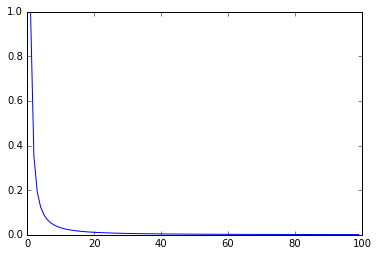

In [9]:
%matplotlib inline
F = np.arange(100)
plt.plot(F, 100*F**(-1.5))

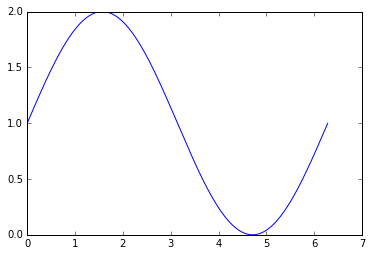

In [2]:
# Let's start with a sine curve... 
time = np.linspace(start=0,stop=2*np.pi, num=1000)
F_true = np.sin(time)+1.0

%matplotlib inline
plt.plot(time,F_true)
plt.axhline(0)



" ...we define $5\sigma$ level as the robust 25-th percentile (or median) of the $F_{true}$ distribution :  $\sigma_{F} = (1/5)  F_{25 \%}$."

In [134]:
sigmaF = 0.2 * np.percentile(F_true,25)
sigmaF

0.058801315983781827

"...Thus we defined $F_{obs}$ as $F_{true} + F_{noise}$, with the Gaussian noise $F_{noise} = \sigma_{F}  \, N(0,1)$ ."

In [135]:
# Generate Gaussian noise with 0 mean and unit width 
noise = np.random.normal(loc=0, scale=1, size=len(time))

In [136]:
F_obs = F_true + sigmaF*noise

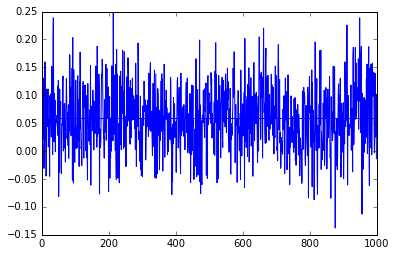

In [137]:
plt.plot(sigmaF+sigmaF*noise)
plt.axhline(sigmaF)

"... . $F_{L}$ is the likelihood associated with each measurement. A measurement $F_{obs}$ is an average of the likelihood : $F_{obs} = \langle F_{L} \rangle$.  For each point of $F_{obs}$  we consider a normalized Gaussian $N(\mu=0, \sigma=1)$, where $x^{*} = \langle F_{L} \rangle / \sigma_{F} =  F_{obs} / \sigma_{F}$, is  a position from which we  calculate the area $A = \int_{x^{*}}^{\infty} {F_{L}}$, defining by $x_{B}$ a point where the $ \int_{x_{B}} ^{\infty} {F_{L}}= 0.05 A$  . Then  the upper limit on our measurement  is  $F_{faint} ^ {upper} = (x_{B} + x^{*}) \, \sigma_{F}$"

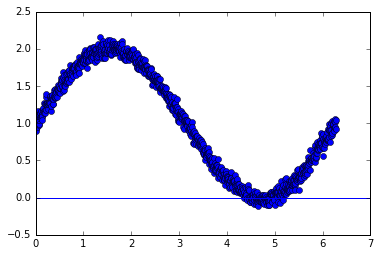

In [138]:
plt.plot(time, F_obs, linestyle = ' ', marker='o')
plt.axhline(0)

## Plot 1 : Generate sinusoidal lightcurve, consider Gaussian sampling with Euclidean counts

In [82]:
dir_save = '/astro/users/suberlak/S13Agg_analysis/data_products/'

This means that we make a time-series where 
F_true  = A*sin(t)+B

and 
sigma = constant = 25-th percentile of sorted  F_true distribution (which with A=1 and B=1 ranges from 0 to 2 ) 

then we scale the distribution of F_true values by sigma, thus considering x_true = F_true  / sigma . 

The observed points corresponding to each F_true are drawn from a Gaussian distribution   ($p(F) \sim \mathcal{N}(F_{true}, \sigma)$), centered on F_true, with a width sigma.   For a scaled x_true,  the distribution is centered on x_true, with a width of 1.

If the number of possible sources was constant with decreasing flux (increasing magnitudes), then the plot of x_true vs x_obs, assuming we draw a 100 observations at the same time of each x_true , so that there are 100 values of x_obs for each x_true  would be : 


In [13]:
# Generate 1000 true points 
time = np.linspace(start=0,stop=2*np.pi, num=1000)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 
# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of 100 Gaussian draws each 
for i in range(len(x_true)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    x_obs_i = np.random.normal(loc=x_true[i], scale = 1, size = 100)
    x_obs.append(x_obs_i)


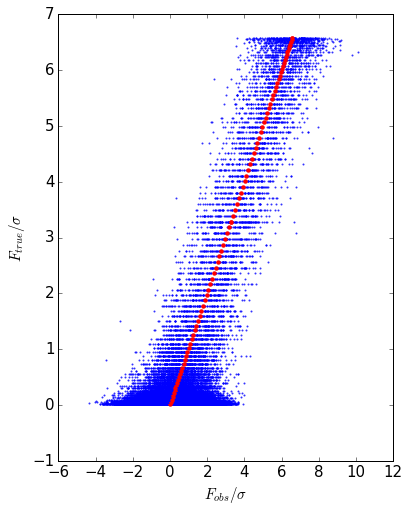

In [89]:
%matplotlib inline
fig, ax= plt.subplots(figsize=(6,8))

for i in range(len(x_true)):
    x_obs_i = x_obs[i]
    x_true_i = x_true[i]
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    ax.scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    ax.scatter(x_true_i, x_true_i, color='red', lw=0)
ax.set_ylabel(r'$F_{true} / \sigma$', fontsize=15)
ax.set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig(dir_save+'Sim_LC_x_obs_vs_x_true_constant_counts.png')

However, the number of sources increases with decreasing flux (increasing magnitudes), according to Euclidean cumulative distribution function:

$N(>F) \propto F ^{-1.5}$  , or $N(m) \propto 10^ {0.6 m }$

this means that our distribution of possible flux as we go to fainter objects (lower S/N) becomes wider , as there is more x_obs points per each x_true towards the faint end : 

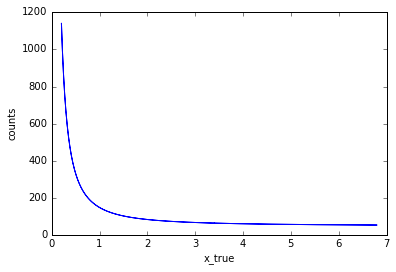

In [42]:
# Generate 1000 true points 
time = np.linspace(start=0,stop=2*np.pi, num=1000)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 

# Choose points with S/N > 0.2 ... 
n0 = 100
mask_close_zero = x_true>0.2
n = n0 * x_true[mask_close_zero] **(-1.5)+50
plt.plot(x_true[mask_close_zero], n)
plt.xlabel('x_true')
plt.ylabel('counts')

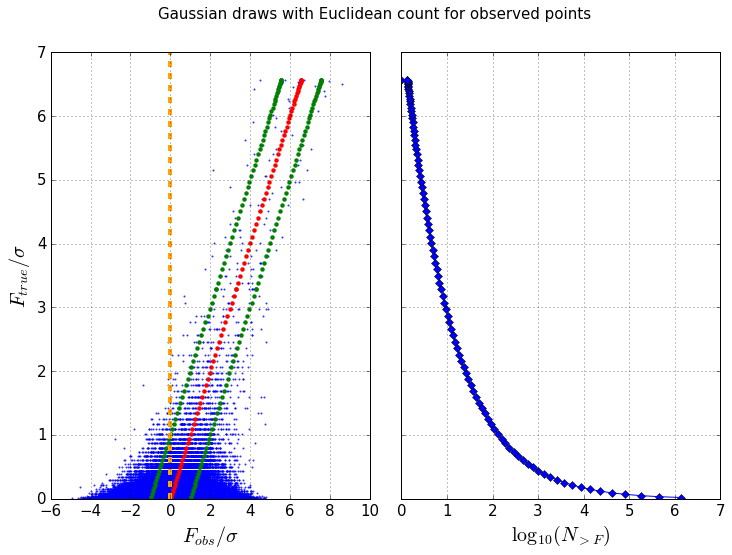

In [385]:
# Generate N true points 
time = np.linspace(start=0,stop=2*np.pi, num=100)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 

# grab only points that are far enough from 0 
# that the number of counts does not become exponentially large... 
mask_close_zero = x_true>0.02

sorted_x = np.sort(x_true[mask_close_zero])

n_counts_cdf = n0 * sorted_x **(-1.5)+50
n_counts_pdf = np.ones_like(n_counts_cdf)

for i in range(len(sorted_x)-1):
    rise = n_counts_cdf[i] - n_counts_cdf[i+1]
    run  = abs(sorted_x[i+1] - sorted_x[i])
    n_counts_pdf[i] = rise / run 

n_counts = n_counts_pdf

# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of N(F) Gaussian draws each 

for i in range(len(sorted_x)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    n = n_counts[i].astype(int)
    x_obs_i = np.random.normal(loc=sorted_x[i], scale = 1, size = n)
    x_obs.append(x_obs_i)

%matplotlib inline
fig, ax= plt.subplots(1,2,figsize=(12,8), sharey=True)

for i in range(len(sorted_x)):
    x_obs_i = x_obs[i]
    x_true_i = sorted_x[i]
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    ax[0].scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    # mark the mean , the mean of underlying gaussian, i.e. x_true
    ax[0].scatter(x_true_i, x_true_i, color='red', lw=0)
    # mark the +/-  1 sigma level, where we expect 68% of points to be 
    ax[0].scatter(x_true_i-1, x_true_i, color='green', lw=0)
    ax[0].scatter(x_true_i+1, x_true_i, color='green', lw=0)
ax[1].plot(np.log10(n_counts), sorted_x, marker='D')

fig.subplots_adjust(wspace=0.1)
ax[0].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[0].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[1].set_xlabel(r'$\log_{10}(N_{>F})$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid()
ax[1].grid()
ax[0].axvline(x=0, color='orange', ls='--', lw=4)
#plt.tight_layout()
fig.suptitle('Gaussian draws with Euclidean count for observed points', fontsize=15)
plt.savefig(dir_save+'Sim_LC_x_obs_vs_x_true_Euclidean_counts.png')

## Plot 2 : Illustrate p(F)  for a faint point with negative distribution tails

In [168]:
ax.axhline?

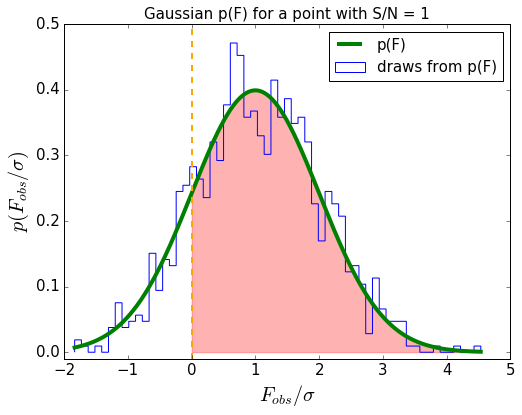

In [203]:
from scipy.stats import norm

x_true = 1
width = 1
#np.random.seed(24)
x_obs = np.random.normal(loc=x_true, scale = width, size = 1000)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(x_obs, normed=True, bins=60, histtype='step' , label='draws from p(F)')

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(min(x_obs), max(x_obs), 0.001)
# Mean = 0, SD = 2.
ax.plot(x_axis,norm.pdf(x_axis,x_true,width), lw=4 , label='p(F)')

# mark the zero
ax.axvline(0,lw=2,ls='--', color='orange')

# mark the posterior
# ax.plot([x1,x2], [y1,y2]) to draw a line from x1,y1 to x2,y2
#ax.plot([min(x_obs), 0], [0, 0], ls='-', color='red', lw=4)
#ax.plot([0,0], [0,norm.pdf(0,x_true,width)],ls='-', color='red', lw=4)

# shade the positive part 
mask = x_axis>0
ax.fill_between(x_axis[mask],norm.pdf(x_axis[mask],x_true,width), alpha=0.3, color='red' )

ax.set_ylim(-.01)
ax.set_ylabel(r'$p(F_{obs}/\sigma)$', fontsize=20)
ax.set_xlabel(r'$F_{obs}/\sigma$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
# save the plot 
ax.set_title('Gaussian p(F) for a point with S/N = 1', fontsize=15)
ax.legend(fontsize=15)
plt.savefig(dir_save + 'Sim_LC_illustrate_pF_mean_1_width_1.png')

## Plot 3 : Illustrate the magnitude depth recovered  by faint signal treatment beyond  $2\sigma$...  

Euclidean number of counts in relation to magnitude obeys : 
    
$N(m) \propto 10^{0.6m}$

In [323]:
ax.text?

2 sigma limit mag is 23.881135
5 sigma limit mag is 22.886285


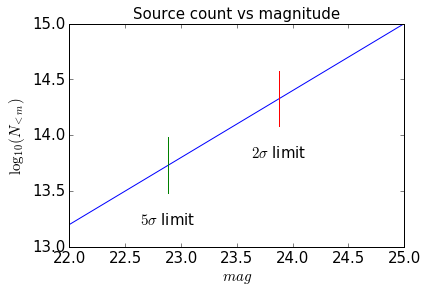

In [341]:
m = np.linspace(22,25,100)
mean_sigma = np.median(fp_data['psfFluxErr'].values) #1.2E-30
m_2sig = -2.5 * np.log10(2*mean_sigma) - 48.6
m_5sig = -2.5 * np.log10(5*mean_sigma) - 48.6
print('2 sigma limit mag is %f'%m_2sig)
print('5 sigma limit mag is %f'%m_5sig)
fig,ax = plt.subplots()
ax.plot(m, np.log10(10**(0.6*m)))

# plot 5 sigma limit 
linesize = 0.25
y1y2 = [ np.log10(10**(0.6*m_5sig))-linesize,np.log10(10**(0.6*m_5sig))+linesize]
x1x2 = [m_5sig, m_5sig ]
ax.plot(x1x2, y1y2)
ax.text(x=m_5sig-0.25,y=13.2,s=r'$5 \sigma$ limit', fontsize=15)

# plot 2 sigma limit 
linesize = 0.25
y1y2 = [ np.log10(10**(0.6*m_2sig))-linesize,np.log10(10**(0.6*m_2sig))+linesize]
x1x2 = [m_2sig, m_2sig ]
ax.plot(x1x2, y1y2)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.text(x=m_2sig-0.25,y=13.8,s=r'$2 \sigma$ limit', fontsize=15)
ax.set_xlabel(r'$mag$', fontsize=15)
ax.set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=15)
ax.set_title('Source count vs magnitude', fontsize=15)
plt.savefig(dir_save+'Source_count_vs_magnitude.png')

I could measure the N(m) : take several thousands of the raw FP lightcurves, do the faint-point treatment, recalculate to magnitudes, and plot how many points do we have in total up to a certain magnitude (cumulative distribution)

In [245]:

DirIn = '/astro/store/scratch/tmp/suberlak/S13Agg/rawDataFPSplit/'
name = 'g00_21.csv'
fp_data = pd.read_csv(DirIn+name+'.gz', compression='gzip',  
                     usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'], nrows=10000)


In [247]:
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
import faintFunctions as faintF 

In [248]:
####  first drop all NaNs  in psfFlux...      
m1  = np.isnan(fp_data['psfFlux'])  # True if NaN  
m2 =  ~np.isfinite(fp_data['psfFlux']) #  True if not finite  
m  = m1 | m2  # a logical or 
if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    fp_data.drop(m.index[m], inplace=True)  # drop entire rows 
    print('Okay, we dropped %d rows where psfFlux is NaN or inf'%np.sum(m))

#### check to make sure that there are no NaN or 0 psfFluxErr... 
m1  = np.isnan(fp_data['psfFluxErr'])  # True if NaN  
m2 =  ~np.isfinite(fp_data['psfFluxErr']) #  True if not finite
m3 =   fp_data['psfFluxErr'].values == 0 # True if Err == 0  (IN2P3 problem...)
m  = m1 | m2 | m3  # a logical or 
if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    fp_data.drop(m.index[m], inplace=True)
    print('Okay, we dropped %d rows where psfFluxErr is NaN or inf'%np.sum(m))

# make a new column, fill with 0's
fp_data['flagFaint'] = 0

# mask those rows that correspond to SNR < 2
mask = (fp_data['psfFlux'].values / fp_data['psfFluxErr'].values) < 2

# print info how many points are affected
print('There are %d points of %d that have SNR<2' %(np.sum(mask),len(mask)))

# set flag at those rows to 1
fp_data.ix[mask, 'flagFaint'] = 1

# make new columns for  Mean  Median  2 sigma...
fp_data['faintMean'] = np.nan
fp_data['faintMedian'] = np.nan
fp_data['faintTwoSigma'] = np.nan
fp_data['faintRMS'] = np.nan
# calculate the faint replacement only for faint points...
print('Faint points treatment...')
fp_data.ix[mask, 'faintMean'] = faintF.calculate_mean(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintMedian'] = faintF.calculate_median(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintTwoSigma'] = faintF.calculate_2sigma(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintRMS'] = faintF.calculate_rms(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)

#
##########  STEP 2 : Derived Quantities ###########  
#

####  replace all psfFlux  where SNR < 2  with  faintMean  
rows = fp_data['flagFaint'] == 1
fp_data.ix[rows, 'psfFlux'] = fp_data.ix[rows, 'faintMean']

def flux2absigma(flux, fluxsigma):
  """Compute AB mag sigma given flux and flux sigma"""
  FIVE_OVER_2LOG10 = 1.085736204758129569
  return FIVE_OVER_2LOG10 * fluxsigma / flux;


def flux2ab(flux):
  """Compute AB mag given flux"""
  return -2.5 * np.log10(flux) - 48.6;

fp_data['psfMag'] = flux2ab(fp_data['psfFlux'])
fp_data['psfMagErr'] = flux2absigma(fp_data['psfFlux'],fp_data['psfFluxErr'])

print('Calculating magnitudes from fluxes is finished')

There are 5464 points of 10000 that have SNR<2
Faint points treatment...
Calculating magnitudes from fluxes is finished


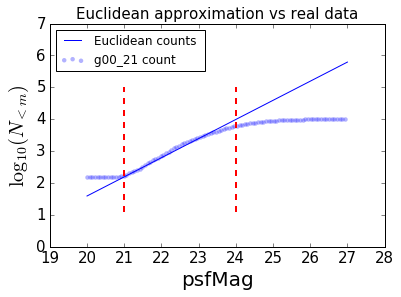

In [347]:
m = np.linspace(20,27,100)
N_cumulative = np.zeros_like(m)
N_between_m = np.zeros_like(m)
for i in range(len(m)-1):
    N_between_m[i] = np.sum((fp_data['psfMag'].values >m[i])&(fp_data['psfMag'].values <m[i+1]))
    N_cumulative[i] = np.sum(fp_data['psfMag'].values < m[i])
    
fig,ax = plt.subplots()
from scipy.optimize import curve_fit

def func(m, b):
    return np.log10(10**(0.6*m))+b

mask = (m>22) & (m<24)
popt, pcov = curve_fit(func, m[mask], np.log10(N_cumulative[mask]))


ax.scatter(m, np.log10(N_cumulative),  label='g00_21 count', alpha=0.3, lw=0)
ax.plot(m, func(m,popt[0]), label='Euclidean counts ')
ax.legend(loc='best', fontsize=12)
ax.set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=20)
ax.set_xlabel('psfMag', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.plot([21,21],[1.1,5], color='red', ls='--', lw=2)
ax.plot([24,24],[1.1,5], color='red', ls='--', lw=2)
ax.set_title('Euclidean approximation vs real data', fontsize=15)
plt.savefig(dir_save+'Simulated_vs_obs_counts_one_patch_raw_FP.png')

Not very convincing.... ? 

In [286]:
max(fp_data['psfMag'].values)

26.90998008438897

In [212]:
# Read-in one patch-filter file, to get mean psfFluxErr .... 
import pandas as pd 
data_source = 'NCSA'
dir_var_stats =  '/astro/store/scratch/tmp/suberlak/s13_stripe82/forced_phot_lt_23/'+data_source+'/Var/'

filter = 'u'
patch= '00_21'
File = 'Var'+filter+patch+'.csv'
varMetrics = pd.read_csv(dir_var_stats+File)

In [219]:
varMetrics.columns

Index([u'objectId', u'N', u'avgMJD', u'chi2DOF', u'chi2R', u'flagLtTenPts',
       u'muFull', u'psfFluxMean', u'psfFluxMeanErr', u'psfFluxMedian',
       u'psfFluxMedianErr', u'psfFluxSigG', u'psfFluxSkew', u'psfFluxStDev',
       u'rangeMJD', u'sigmaFull', u'psfMean', u'psfMedian', u'psfMeanErr',
       u'psfMedianErr'],
      dtype='object')

25.4494718957


In [ ]:
ax[1].plot

In [ ]:
ax[1].plot

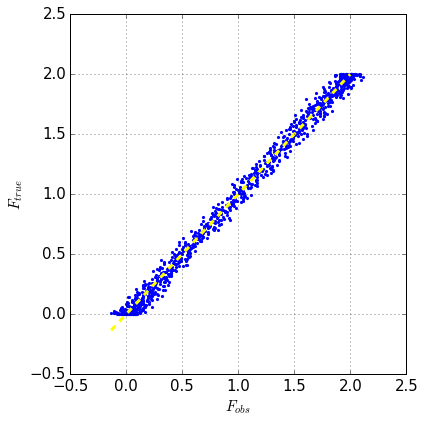

In [49]:
%matplotlib inline 
# Let's start with a sine curve... 
time = np.linspace(start=0,stop=2*np.pi, num=1000)
F_true = np.sin(time)+1.0

sigmaF = 0.2 * np.percentile(F_true,25)
# Generate Gaussian noise with 0 mean and unit width 
noise = np.random.normal(loc=0, scale=1, size=len(time))
F_obs = F_true + sigmaF*noise

fig,ax = plt.subplots(figsize=(6,6))
#ax.scatter(F_obs[F_obs < 2*sigmaF], F_true[F_obs < 2*sigmaF])
ax.scatter(F_obs, F_true, s=10, lw=0)

ax.grid()
x=np.linspace(min(F_obs), max(F_true))
ax.plot(x,x, lw=3, ls='--', c='yellow')
#ax.set_ylim(0,0.02)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$F_{obs}$', fontsize=15)
ax.set_ylabel(r'$F_{true}$', fontsize=15)
plt.tight_layout()
plt.savefig('F_obs_F_true_sinusoidal_LC_Euclidean_counts.png')

In [9]:
F

(1000,)

In [139]:
# The Gaussian likelihood for a single point 
#F_l = np.random.normal(loc=F_obs[0], scale=abs(sigmaF), size=len(time))
#plt.hist(F_l)
#np.median(F_l)


## Explore deeper calculation of F_mean... 

In [301]:
fObs = -0.2
print('F_{obs}=%.2f, \sigma_{F} = %f'%(fObs, sigmaF))
fMean = np.sqrt((sigmaF ** 2.0)/2*np.pi) * np.exp(-(fObs**2.0) / (2*sigmaF**2.0)) +\
        (fObs / 2.0) * erfc(-fObs / (sigmaF * np.sqrt(2)))
print('F_{mean}=%f'%fMean)

F_{obs}=-0.20, \sigma_{F} = 0.058801
F_{mean}=0.000160


In [300]:
fObs = np.linspace(-0.)

F_{mean}=0.000160


In [62]:
import scipy.special as sp


In [86]:
time = np.linspace(start=0,stop=2*np.pi, num=1000)
F_true = np.sin(time)+1.0
sigmaF = 0.2 * np.percentile(F_true,25)
noise = np.random.normal(loc=0, scale=1, size=len(time))
F_obs = F_true + sigmaF*noise

Flux = F_obs
FluxErr = sigmaF * np.ones_like(Flux) 


In [2]:
#FluxErr

## Faint signal treatment : analytical integration

Commented out are lines where I was calculating xMean, xRms by hand - these same functions are now 
part of faintFunctions.py,  so I used faintF  with some arbitrary sigma (because faintF  needs flux and flux_error, even though the actual calculation is done on x_obs = flux / flux_err )

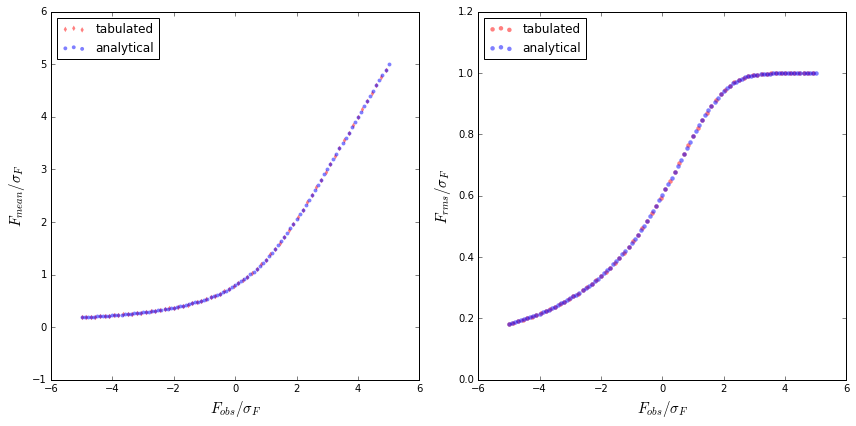

In [11]:
import numpy as np
import scipy.special as sp
from scipy.stats import norm
from scipy.special import erfc
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
import faintFunctions as faintF 

%matplotlib inline

# Compare Zeljko's calculation with mine... 
data = np.genfromtxt('posteriorF.dat', comments='#')
xObs , expF , rmsF = data[:,0], data[:,1], data[:,2]

# mock sigma to use my varF 
sigma = 0.01
fObs= xObs * sigma
sigObs = np.ones_like(fObs) * sigma

fMean = faintF.calculate_mean(fObs, sigObs)
xMean = fMean / sigma
#xMean = (np.exp(-(xObs**2.0) / 2.0) / (norm.sf(-xObs )*np.sqrt(2*np.pi))) + xObs

#delX = xObs - xMean
#I1 = norm.sf(-xObs)
#I0bysig2 = 0.5*sp.erf(xObs/np.sqrt(2)) + (1.0/np.sqrt(2*np.pi))*np.exp(-(xObs**2.0) / 2.0)*(2*delX - xObs) + 0.5 + delX*delX*norm.sf(-xObs)
#(1.0/np.sqrt(2*np.pi))*((np.sqrt(2*np.pi) + delX**2.0 )*norm.sf(-xObs)  - 2*xMean*np.exp(-(xObs**2.0) / 2.0))
#xRms = np.sqrt(I0bysig2 / I1) 
fRms= faintF.calculate_rms(fObs, sigObs)
xRms = fRms/ sigma

fig,ax = plt.subplots(1,2, figsize=(12,6))
size=15
ax[0].scatter(xObs[::15], expF[::15] , lw=0, s=size ,alpha=0.5, color='red', marker = 'd',label='tabulated' )
ax[0].scatter(xObs[::10] , xMean[::10], lw=0, s=size, alpha=0.5, color='b',label='analytical')
ax[0].set_xlabel(r'$F_{obs} / \sigma_{F}$', fontsize=15)
ax[0].set_ylabel(r'$F_{mean}/ \sigma_{F}$', fontsize=15)
ax[0].legend(loc='upper left')
ax[1].scatter(xObs[::15], np.sqrt(rmsF[::15]), lw=0, alpha=0.5, color='red',label='tabulated')
ax[1].scatter(xObs[::10], xRms[::10], lw=0, alpha=0.5, color='blue',label='analytical')
ax[1].set_xlabel(r'$ F_{obs} / \sigma_{F}$', fontsize=15)
ax[1].set_ylabel(r'$ F_{rms} / \sigma_{F}$', fontsize=15)
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.savefig('F_obs_F_mean_scaled.png')

## Faint signal treatment : direct integration 

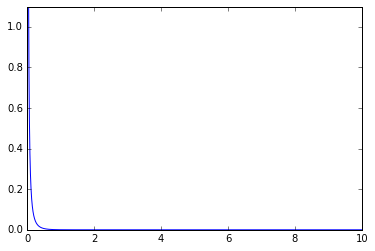

In [37]:
x_obs = -3
plt.ylim(0,1.1)
plt.plot(x, x**(-1.5)*np.exp(-((x-x_obs)**2.0) / 2.0))

In [66]:
x = np.arange(0.01,10,0.001)
x_obs = 2 
f0 = np.exp(-((x-x_obs)**2.0) / 2.0)  # normalization
rhs = 0.05 * np.sum(f0)
try_sum = np.zeros_like(x)
for i in range(len(x)) : 
    try_sum[i] = np.sum(np.exp(-((x[i:]-x_obs)**2.0) / 2.0))

In [71]:
try_sum[try_sum == rhs]

array([], dtype=float64)

In [18]:
import numpy as np

x = np.arange(0.01,15,0.001)
xOBS = np.linspace(-5,10, 1000) 
x2SIG = []

for x_obs in xOBS : 
    lhs = []
    f0 = np.exp(-((x-x_obs)**2.0) / 2.0) 

    rhs = 0.05 * np.sum(f0)

    for i in range(len(x)):
        sum_i = np.sum(f0[i:])
        lhs.append(sum_i)

    abs_diff = np.abs(lhs-rhs)
    lhs_arr = np.array(lhs)
    msk = abs_diff == np.min(abs_diff)
    x_2sig = x[msk][0]
    
    x2SIG.append(x_2sig)

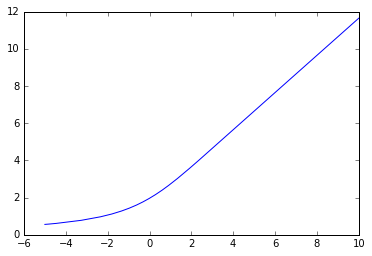

In [19]:
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.plot(xOBS,x2SIG)

In [83]:
## Calculate the mean, rms , in a direct way (by direct integration over x-grid), like Zeljko did in SM 
import numpy as np
import matplotlib.pyplot as plt 

x = np.arange(0.01,15,0.001)
xOBS = np.linspace(-5,10, 1000) # F_obs / sigmaF
xM = []
xRMS = []
xM_euc = []
xRMS_euc = []
x2SIG = []
x2SIG_euc = []

for x_obs in xOBS : 
    # integrate over x, 0 to 10 sufficient since exp(-100) ~ 0 
    
    # Gaussian likelihood and flat prior
    # x_mean  = F_mean / sigmaF
    f0 = np.exp(-((x-x_obs)**2.0) / 2.0)  # normalization
    f1 = x*np.exp(-((x-x_obs)**2.0) / 2.0)  # mean
    x_mean = np.sum(f1) / np.sum(f0)
    xM.append(x_mean)
    # x_rms = root-mean-square / sigmaF

    g0 = f0
    g1 = ((x-x_mean)**(2.0)) * f0

    x_rms =np.sqrt(np.sum(g1) / np.sum(g0))
    xRMS.append(x_rms)  # this is the square of the rms, to compare with Z's calculation
    
    lhs = []
    rhs = 0.05 * np.sum(f0)

    for i in range(len(x)):
        sum_i = np.sum(f0[i:])
        lhs.append(sum_i)

    abs_diff = np.abs(lhs-rhs)
    lhs_arr = np.array(lhs)
    msk = abs_diff == np.min(abs_diff)
    x_2sig = x[msk][0]
    
    x2SIG.append(x_2sig)
    

    
    # Gaussian likelihood and Euclidean prior 
    # x_mean  = F_mean / sigmaF
    f0 = x**(-1.5)*np.exp(-((x-x_obs)**2.0) / 2.0)  # normalization
    f1 = x**(-1.5)*x*np.exp(-((x-x_obs)**2.0) / 2.0)  # mean
    x_mean = np.sum(f1) / np.sum(f0)
    xM_euc.append(x_mean)
    # x_rms = root-mean-square / sigmaF

    g0 = f0
    g1 = ((x-x_mean)**(2.0)) * f0

    x_rms =np.sqrt(np.sum(g1) / np.sum(g0))
    xRMS_euc.append(x_rms)  # this is the square of the rms, to compare with Z's calculation
    
    # x_2sig   is where the integral from x_2sig to inf  is 0.05 of the integral from 
    # 0 to infty (i.e. over the entire normalized range)
    # no need to normalize because both sums (lhs and rhs ) would be divided by the same integral 
    lhs = []
    rhs = 0.05 * np.sum(f0)

    for i in range(len(x)):
        sum_i = np.sum(f0[i:])
        lhs.append(sum_i)

    abs_diff = np.abs(lhs-rhs)
    lhs_arr = np.array(lhs)
    msk = abs_diff == np.min(abs_diff)
    x_2sig = x[msk][0]
    
    x2SIG_euc.append(x_2sig)
    

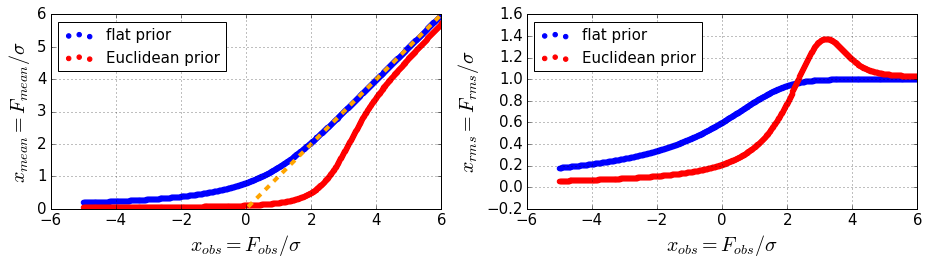

In [86]:
%matplotlib inline
fig,ax = plt.subplots(1,2, figsize=(13,3.8))
# flat prior
ax[0].plot(xOBS, xOBS, ls='--', color='orange', lw=4)
ax[0].scatter(xOBS, xM, color='blue', label='flat prior')
ax[1].scatter(xOBS, xRMS, color='blue', label='flat prior')

# Euclidean prior 
ax[0].scatter(xOBS, xM_euc, color='red', label='Euclidean prior')
ax[1].scatter(xOBS,xRMS_euc, color='red',label='Euclidean prior')

ax[0].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[0].set_ylabel(r'$x_{mean}= F_{mean} / \sigma$', fontsize=20)
ax[1].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[1].set_ylabel(r'$x_{rms}= F_{rms} / \sigma$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid()
ax[1].grid()
ax[0].legend(loc='upper left', fontsize=15)
ax[1].legend(loc='upper left', fontsize=15)
ax[0].set_xlim(-6,6)
ax[1].set_xlim(-6,6)
ax[0].set_ylim(0,6)
fig.subplots_adjust(wspace=0.3,)
plt.tight_layout()
plt.savefig('/astro/users/suberlak/S13Agg_analysis/data_products/'+'Fig3_direct_integration_priors.png')

In [87]:
data = np.column_stack((xOBS, xM_euc, xRMS_euc))
np.savetxt('/astro/users/suberlak/S13Agg_analysis/data_products/'+'Fig3_xObs_xMean_xRms_euc_prior.txt', data )

data = np.column_stack((xOBS, xM, xRMS))
np.savetxt('/astro/users/suberlak/S13Agg_analysis/data_products/'+'Fig3_xObs_xMean_xRms_flat_prior.txt', data )



In [35]:
# Compare Zeljko's calculation with mine... 
data = np.genfromtxt('posteriorF.dat', comments='#')
xObs , expF , rmsF = data[:,0], data[:,1], data[:,2]

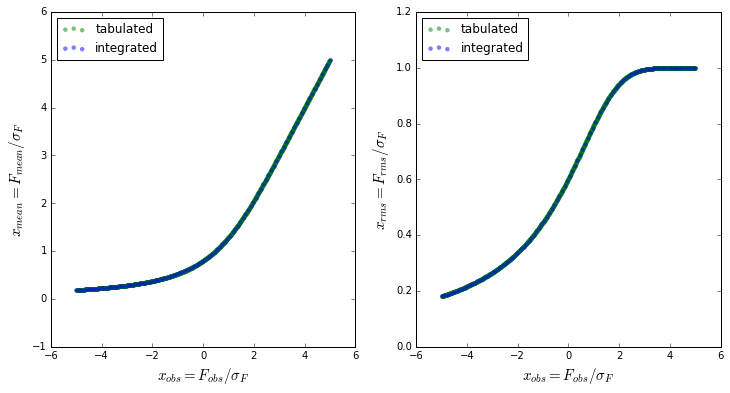

In [59]:
# Plot how Zeljko's calculation and mine using direct integration are identical... 
%matplotlib inline
fig,ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(xObs, expF, lw=0, alpha=0.5, color='green',label='tabulated')
ax[0].scatter(xOBS, xM, lw=0, alpha=0.5, color='blue',label='integrated')
ax[0].set_xlabel(r'$x_{obs} = F_{obs} / \sigma_{F}$', fontsize=15)
ax[0].set_ylabel(r'$x_{mean}= F_{mean} / \sigma_{F}$', fontsize=15)
ax[0].legend(loc='upper left')
# need to take a square-root of Zeljko's rmsto compare... 
ax[1].scatter(xObs, np.sqrt(rmsF), lw=0, alpha=0.5, color='green',label='tabulated')
ax[1].scatter(xOBS, np.array(xRMS), lw=0, alpha=0.5, color='blue',label='integrated')
ax[1].set_xlabel(r'$x_{obs} = F_{obs} / \sigma_{F}$', fontsize=15)
ax[1].set_ylabel(r'$x_{rms}= F_{rms} / \sigma_{F}$', fontsize=15)
ax[1].legend(loc='upper left')
#fig.subplots_adjust(wspace=0)

In [4]:
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
# faint source treatment 
import faintFunctions as faintF 

faintF.calculate_2sigma?

In [18]:
# Plot how Zeljko's calculation and mine using calculation from closed form integral is equivalent


F_faint = F_obs[F_obs < 2*sigmaF]
xObs= F_faint/sigmaF
xMean = (1/ (norm.sf(-xObs )*np.sqrt(2*np.pi))) * np.exp(-(xObs**2.0) / 2.0) + xObs
F_mean = xMean * sigmaF
x0= -F_faint / sigmaF
F_median = sigmaF*norm.ppf((1+norm.cdf(x0))/2.0) + F_faint
F_2sig = F_faint + sigmaF * norm.isf(0.05 * norm.sf(x0)) 


NameError: name 'F_obs' is not defined

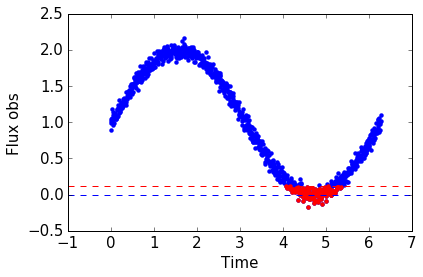

In [243]:
fig,ax = plt.subplots()
ax.scatter(time, F_obs,  marker='o', lw=0)
ax.scatter(time[F_obs < 2*sigmaF],F_obs[F_obs < 2*sigmaF], marker='o', lw=0, color='red')
ax.axhline(0, ls='--')
ax.axhline(2*sigmaF, c='red', ls='--')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Flux obs', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('Flux_exp_full_lc.png')
#plt.setp(line, edgecolors='None') 

In [303]:
FobsSim

array([-5.  , -4.99, -4.98, ...,  4.98,  4.99,  5.  ])

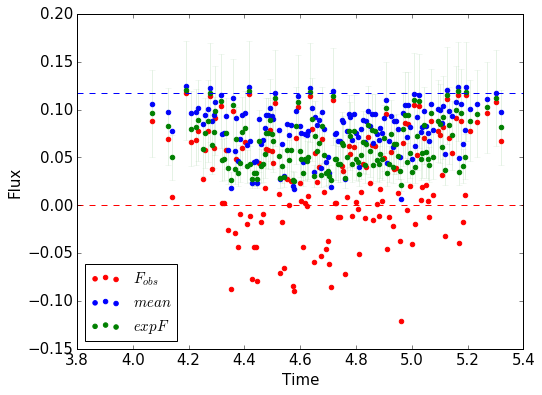

In [274]:
fig,ax = plt.subplots(figsize=(8,6))
t = time[F_obs < 2*sigmaF]

ax.scatter(t,F_faint , color='red', label=r'$F_{obs}$')
ax.scatter(t, F_mean, color='blue',label=r'$mean$')
ax.scatter(t, expF_interp*sigmaF , color='green', label=r'$expF$')
ax.errorbar(t,expF_interp*sigmaF, rmsF_interp*sigmaF, linestyle='None', alpha=0.1, color='green' )
ax.axhline(0, c='red', ls='--')
ax.axhline(2*sigmaF, c='blue', ls='--')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Flux', fontsize=15)
ax.legend(loc = 'lower left', fontsize=15)

plt.savefig('Flux_exp_faint_simulated_overplot.png')

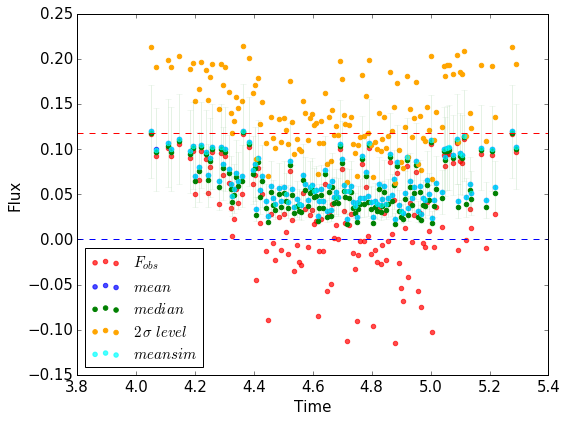

In [46]:
# compare all four methods...  
# normalize the mean by the integral of probability ! 
#i.e.  norm = int(p(F) dF)  so that 
# F_mean  = int (F*p(F)) / norm

# Let's start with a sine curve... 
time = np.linspace(start=0,stop=2*np.pi, num=1000)
F_true = np.sin(time)+1.0

sigmaF = 0.2 * np.percentile(F_true,25)
# Generate Gaussian noise with 0 mean and unit width 
noise = np.random.normal(loc=0, scale=1, size=len(time))
F_obs = F_true + sigmaF*noise

# Grab the faint points...
F_faint = F_obs[F_obs < 2*sigmaF]

# normalize by sigmaF
xObs= F_faint/sigmaF

# calculate the limit normalized... 
x0= -F_faint / sigmaF

# Read in Zeljko's table ... 
data = np.genfromtxt('posteriorF.dat', comments='#')
xObsSim, expFnorm , rmsFnorm = data[:,0], data[:,1], data[:,2]

# Interpolate results :  from the tabulated results for xp = FobsSim, fp =  expF,   
# need to extrapolate expF on points  defined by x= F_faint   
# xp must be increasing - but FobsSim already is :) 

expFnorm_interp = np.interp(x = F_faint / sigmaF, xp = xObsSim ,fp= expFnorm)
rmsFnorm_interp = np.interp(x = F_faint / sigmaF,  xp = xObsSim, fp = rmsFnorm)

# rescale to compare to mine 
F_mean_sim  = expFnorm_interp * sigmaF
F_rms_sim = rmsFnorm_interp * sigmaF

# Calculate my results 

xMean = (1/ (norm.sf(-xObs )*np.sqrt(2*np.pi))) * np.exp(-(xObs**2.0) / 2.0) + xObs

F_mean = xMean * sigmaF
F_median = sigmaF*norm.ppf((1+norm.cdf(x0))/2.0) + F_faint
F_2sig = F_faint + sigmaF * norm.isf(0.05 * norm.sf(x0)) 

# plot all on the same plot

fig,ax = plt.subplots(figsize=(8,6))
t = time[F_obs < 2*sigmaF]

ax.scatter(t,F_faint, color='red', label=r'$F_{obs}$', alpha=0.7)
ax.scatter(t, F_mean, color='blue',label=r'$mean$',alpha=0.7)
ax.scatter(t, F_median, color='green',label=r'$median$')
ax.scatter(t, F_2sig, color='orange',label=r'$2 \, \sigma \,\, level$')
ax.scatter(t, F_mean_sim, color='cyan',label=r'$mean sim$', alpha=0.7)
ax.errorbar(t,F_mean_sim, F_rms_sim, linestyle='None', alpha=0.1, color='green' )
ax.axhline(0, ls='--')
ax.axhline(2*sigmaF, c='red', ls='--')
ax.set_xlabel('Time', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('Flux', fontsize=15)
ax.legend(loc = 'lower left', fontsize=15)
plt.tight_layout()
plt.savefig('Flux_exp_faint.png')

In [50]:
# compare which is quicker : interpolate or calculate from first principles ? 

# Read in Zeljko's table ... 
data = np.genfromtxt('posteriorF.dat', comments='#')
xObsSim, expFnorm , rmsFnorm = data[:,0], data[:,1], data[:,2]


def interpolate_mean(F_obs,sigmaF):
    # Interpolate results :  from the tabulated results for xp = FobsSim, fp =  expF,   
    # need to extrapolate expF on points  defined by x= F_faint   
    # xp must be increasing - but FobsSim already is :) 
    xObs = F_obs / sigmaF
    expFnorm_interp = np.interp(x = xObs, xp = xObsSim ,fp= expFnorm)
    # rescale to compare to mine 
    F_mean_sim  = expFnorm_interp * sigmaF
    return F_mean_sim

def calculate_mean(F_obs,sigma):
    xObs = F_obs / sigmaF
    # Calculate my results 
    xMean = (1/ (norm.sf(-xObs )*np.sqrt(2*np.pi))) * np.exp(-(xObs**2.0) / 2.0) + xObs
    F_mean = xMean * sigmaF
    return F_mean




In [49]:
%timeit interpolate_mean

The slowest run took 136.51 times longer than the fastest. This could mean that an intermediate result is being cached.
100000000 loops, best of 3: 18.6 ns per loop


In [51]:
%timeit calculate_mean

10000000 loops, best of 3: 20.3 ns per loop


In [53]:
len(F_obs)

1000

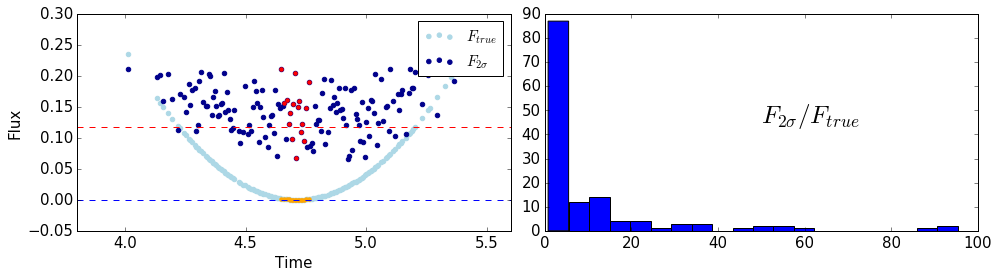

In [307]:
# HISTOGRAMS  

# 1) F_2sig / F_true 

fig,ax = plt.subplots(1,2, figsize=(14,4))
F_t = F_true[F_obs < 2*sigmaF]

msk = abs(F_2sig / F_t) > 100
ax[0].scatter(t,F_t, color='lightblue', label=r'$F_{true}$')
ax[0].scatter(t,F_2sig, color='darkblue',label=r'$F_{2 \sigma}$')
ax[0].scatter(t[msk], F_2sig[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
ax[0].set_xlabel('Time', fontsize=15)
ax[0].set_ylabel('Flux', fontsize=15)
msk = abs(F_2sig / F_t) < 100
ax[1].hist(F_2sig[msk] / F_t[msk], bins=20)
ax[1].text(x=0.5, y=0.5, s=r'$F_{2 \sigma} / F_{true}$',transform = ax[1].transAxes, fontsize=25)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].legend(fontsize=15)
plt.tight_layout()
plt.savefig('Flux_hist_1.png')

In [316]:
# Calculate percent of cases where F_true is bigger than F_sigma 

perc = np.sum(F_t < F_2sig) / float(len(F_2sig))
print('F_true < F_2sig in %.2f  percent cases'%(100*perc))

F_true < F_2sig in 97.39  percent cases


F_true < F_2sig in 100.00  percent cases


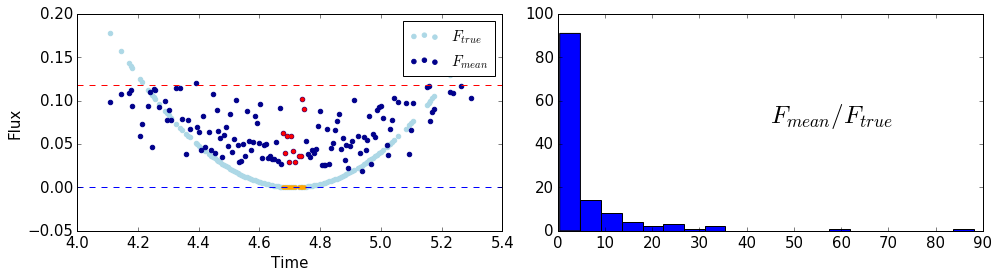

In [30]:
# Calculate percent of cases where F_true is bigger than F_sigma 
F_t = F_true[F_obs < 2*sigmaF]
perc = np.sum(F_t < F_2sig) / float(len(F_2sig))
print('F_true < F_2sig in %.2f  percent cases'%(100*perc))# 2)a)  F_mean / F_true 

fig,ax = plt.subplots(1,2, figsize=(14,4))


msk = abs(F_mean / F_t) > 100
ax[0].scatter(t,F_t, color='lightblue',label=r'$F_{true}$')
ax[0].scatter(t,F_mean, color='darkblue',label=r'$F_{mean}$')
ax[0].scatter(t[msk], F_mean[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
ax[0].legend(fontsize=15)
msk = abs(F_mean / F_t) < 100
ax[1].hist(F_mean[msk] / F_t[msk], bins=20)
ax[0].set_xlabel('Time', fontsize=15)
ax[0].set_ylabel('Flux', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.5, y=0.5, s=r'$F_{mean} / F_{true}$',transform = ax[1].transAxes, fontsize=25)
plt.tight_layout()
plt.savefig('Flux_hist_2a.png')

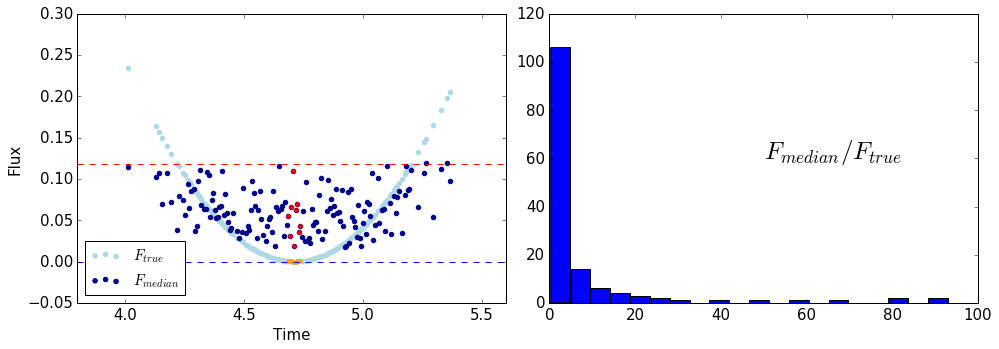

In [305]:
# 2)b)   F_median/  F_true 
fig,ax = plt.subplots(1,2, figsize=(14,5))
F_t = F_true[F_obs < 2*sigmaF]

msk = abs(F_median / F_t) > 100
ax[0].scatter(t,F_t, color='lightblue',label=r'$F_{true}$')
ax[0].scatter(t,F_median, color='darkblue',label=r'$F_{median}$')
ax[0].scatter(t[msk], F_median[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
msk = abs(F_median / F_t) < 100
ax[1].hist(F_median[msk] / F_t[msk], bins=20)
ax[0].set_xlabel('Time', fontsize=15)
ax[0].set_ylabel('Flux', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.5, y=0.5, s=r'$F_{median} / F_{true}$',transform = ax[1].transAxes, fontsize=25)
ax[0].legend(fontsize=15, loc='lower left')
plt.tight_layout()
plt.savefig('Flux_hist_2b.png')

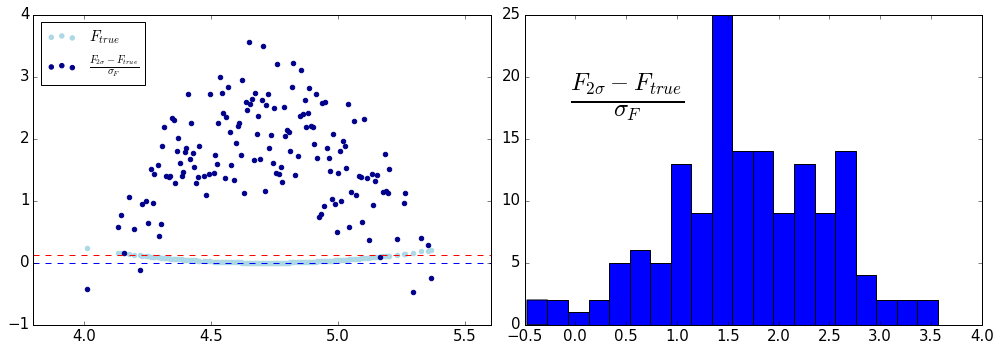

In [299]:
# 3) (F_2sig - F_true)  / sigmaF
fig,ax = plt.subplots(1,2, figsize=(14,5))
F_t = F_true[F_obs < 2*sigmaF]
F_plot = (F_2sig - F_t) / sigmaF
msk = abs(F_plot) > 100
ax[0].scatter(t,F_t, color='lightblue',label=r'$F_{true}$')
ax[0].scatter(t,F_plot, color='darkblue', label =r'$\frac{F_{2 \sigma} - F_{true}}{\sigma_{F}}$' )
ax[0].scatter(t[msk], F_plot[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].legend(fontsize=15, loc='upper left')
ax[0].axhline(2*sigmaF, c='red', ls='--')
msk = abs(F_plot) < 100
ax[1].hist(F_plot[msk], bins=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.1, y=0.7, s=r'$\frac{F_{2 \sigma} - F_{true}}{\sigma_{F}}$',transform = ax[1].transAxes, fontsize=35)
plt.tight_layout()
plt.savefig('Flux_hist_3.png')

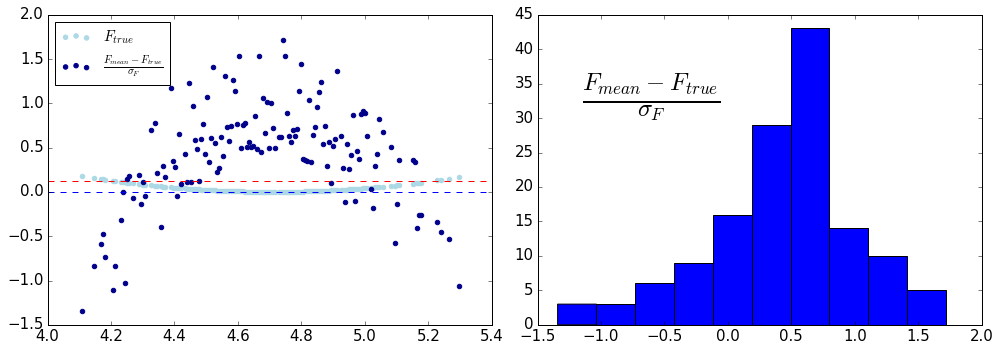

In [31]:
# 4)a) (F_mean - F_true)  / sigmaF
fig,ax = plt.subplots(1,2, figsize=(14,5))
F_t = F_true[F_obs < 2*sigmaF]
F_plot = (F_mean - F_t) / sigmaF
msk = abs(F_plot) > 100
ax[0].scatter(t,F_t, color='lightblue',label=r'$F_{true}$')
ax[0].scatter(t,F_plot, color='darkblue',label =r'$\frac{F_{mean} - F_{true}}{\sigma_{F}}$')
ax[0].scatter(t[msk], F_plot[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
ax[0].legend(fontsize=15, loc='upper left')
msk = abs(F_plot) < 100
ax[1].hist(F_plot[msk])
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.1, y=0.7, s=r'$\frac{F_{mean} - F_{true}}{\sigma_{F}}$',transform = ax[1].transAxes, fontsize=35)
plt.tight_layout()
plt.savefig('Flux_hist_4a.png')

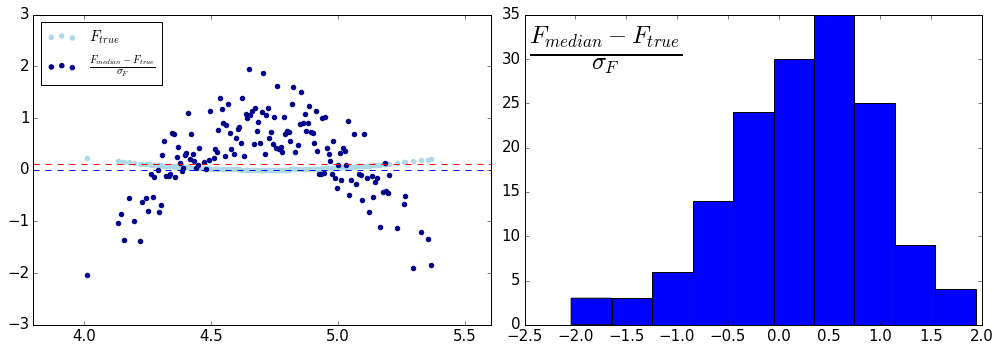

In [301]:
# 4)b) (F_median -  F_true)  / sigmaF
fig,ax = plt.subplots(1,2, figsize=(14,5))
F_t = F_true[F_obs < 2*sigmaF]
F_plot = (F_median- F_t) / sigmaF

msk = abs(F_plot) > 100
ax[0].scatter(t,F_t, color='lightblue', label=r'$F_{true}$')
ax[0].scatter(t,F_plot, color='darkblue', label=r'$\frac{F_{median} - F_{true}}{\sigma_{F}}$')
ax[0].scatter(t[msk], F_plot[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
ax[0].legend(fontsize=15, loc='upper left')
msk = abs(F_plot) < 100
ax[1].hist(F_plot[msk])
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.01, y=0.85, s=r'$\frac{F_{median} - F_{true}}{\sigma_{F}}$',transform = ax[1].transAxes, fontsize=35)
plt.tight_layout()
plt.savefig('Flux_hist_4b.png')

In [32]:
import numpy as np

def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
	'''Simulate a DRW lightcurve for a given time series t, with parameters
	   (SFinf, tau), and mean magnitude.
	   Uses equations A4 and A5 in KBS09 (see also MacLeod+10 sec 2.2).'''
	mu = mean_mag
	mag = np.zeros(len(t),dtype=np.float32)
	mag[0] = mean_mag
	dt = np.diff(t)
	for i in range(1,len(t)):
		loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
		var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
		mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
	return mag



sigmaF = 0.003222


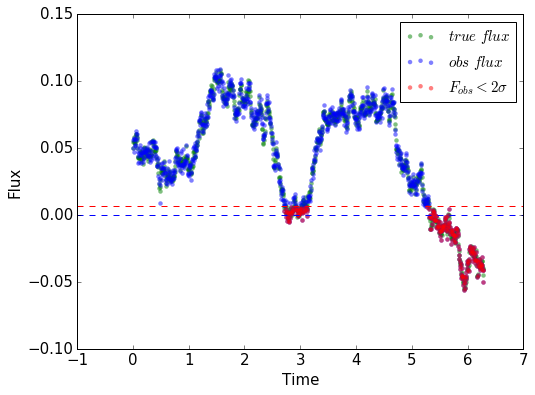

In [38]:
F_true = sim_DRW_lightcurve(time, 0.134, 10,0.05)
sigmaF = abs(0.2 * np.percentile(F_true,25))
noise = np.random.normal(loc=0, scale=1, size=len(time))
F_obs = F_true+sigmaF*noise

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(time,F_true, marker='o', lw=0, color='green', alpha=0.5, label=r'$true \, \, flux$')
ax.scatter(time,F_obs,  marker='o', lw=0, color='blue', alpha=0.5, label=r'$obs \, \, flux$')
ax.scatter(time[F_obs < 2*sigmaF],F_obs[F_obs < 2*sigmaF], marker='o', lw=0, color='red', alpha=0.5, label=r'$F_{obs} <  2 \sigma$')
ax.axhline(0, ls='--')
ax.axhline(2*sigmaF, c='red', ls='--')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Flux', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
print('sigmaF = %f'%sigmaF)
plt.savefig('DRW_flux.png')

In [40]:
# Use Zeljko's lookup table, since we have that 
# <F_obs> =  f(Fobs/sigmaF)*sigmaF
# and similarly for rms...
data = np.genfromtxt('posteriorF.dat', comments='#')
FobsSim , expF , rmsF = data[:,0], data[:,1], data[:,2]

# Need to interpolate results :  from the tabulated results for xp = FobsSim, fp =  expF,   
# need to extrapolate expF on points  defined by x= F_faint   
# xp must be increasing - but FobsSim already is :) 
expF_interp = np.interp(x = F_faint / sigmaF,xp = FobsSim ,fp= expF)
rmsF_interp = np.interp(x=F_faint / sigmaF,  xp = FobsSim, fp = rmsF)


ValueError: x and y must be the same size

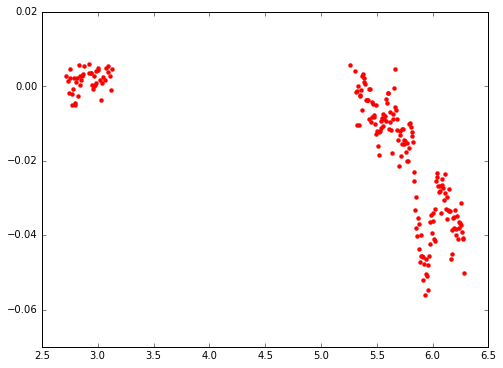

In [41]:
fig,ax = plt.subplots(figsize=(8,6))
t = time[F_obs < 2*sigmaF]
ax.scatter(t,F_obs[F_obs < 2*sigmaF], marker='o', lw=0, color='red')
ax.scatter(t,F_faint, color='red', label=r'$F_{obs}$')
ax.scatter(t, F_mean, color='blue',label=r'$mean$')
#ax.scatter(t, F_median, color='green',label=r'$median$')
#ax.scatter(t, F_2sig, color='orange',label=r'$2 \, \sigma \,\, level$')
ax.scatter(t, expF_interp*sigmaF , color='green', label=r'$expF$')
ax.errorbar(t,expF_interp*sigmaF, rmsF_interp*sigmaF, linestyle='None', alpha=0.3, color='green' )
ax.axhline(0, ls='--')
ax.axhline(2*sigmaF, c='red', ls='--')
ax.set_xlabel('Time', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('Flux', fontsize=15)
ax.legend(loc = 'lower left', fontsize=15)
plt.tight_layout()
plt.savefig('DRW_Flux_exp_faint_lookup_table.png')

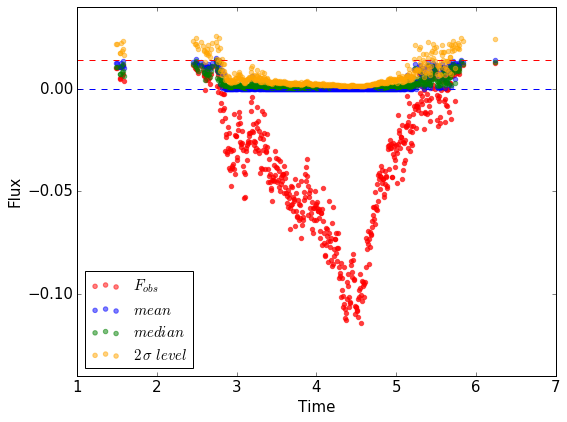

In [193]:
fig,ax = plt.subplots(figsize=(8,6))
t = time[F_obs < 2*sigmaF]
ax.scatter(t,F_obs[F_obs < 2*sigmaF], marker='o', lw=0, color='red', alpha=0.5)
ax.scatter(t,F_faint, color='red', label=r'$F_{obs}$', alpha=0.5)
ax.scatter(t, F_mean, color='blue',label=r'$mean$', alpha=0.5)
ax.scatter(t, F_median, color='green',label=r'$median$', alpha=0.5)
ax.scatter(t, F_2sig, color='orange',label=r'$2 \, \sigma \,\, level$', alpha=0.5)
ax.axhline(0, ls='--')
ax.axhline(2*sigmaF, c='red', ls='--')
ax.set_xlabel('Time', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('Flux', fontsize=15)
ax.legend(loc = 'lower left', fontsize=15)
plt.tight_layout()
plt.savefig('DRW_Flux_exp_faint.png')

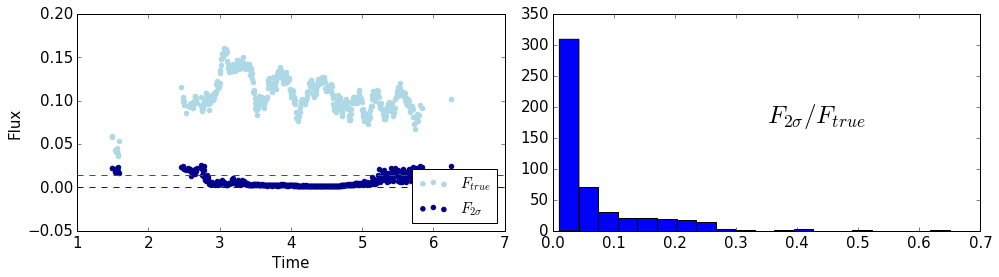

In [194]:
# HISTOGRAMS  

# 1) F_2sig / F_true 

fig,ax = plt.subplots(1,2, figsize=(14,4))
F_t = F_true[F_obs < 2*sigmaF]

hist_lim = 10 

msk = abs(F_2sig / F_t) > hist_lim
ax[0].scatter(t,F_t, color='lightblue', label=r'$F_{true}$')
ax[0].scatter(t,F_2sig, color='darkblue',label=r'$F_{2 \sigma}$')
ax[0].scatter(t[msk], F_2sig[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
ax[0].set_xlabel('Time', fontsize=15)
ax[0].set_ylabel('Flux', fontsize=15)
msk = abs(F_2sig / F_t) < hist_lim
ax[1].hist(F_2sig[msk] / F_t[msk], bins=20)
ax[1].text(x=0.5, y=0.5, s=r'$F_{2 \sigma} / F_{true}$',transform = ax[1].transAxes, fontsize=25)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].legend(fontsize=15, loc='lower right')
plt.tight_layout()
plt.savefig('DRW_Flux_hist_1.png')

F_true < F_2sig in 0.00  percent cases


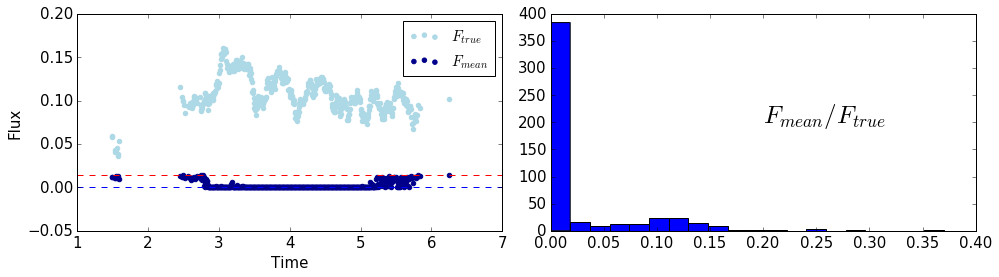

In [195]:
# Calculate percent of cases where F_true is bigger than F_sigma 

perc = np.sum(F_t < F_2sig) / float(len(F_2sig))
print('F_true < F_2sig in %.2f  percent cases'%(100*perc))# 2)a)  F_mean / F_true 

fig,ax = plt.subplots(1,2, figsize=(14,4))
F_t = F_true[F_obs < 2*sigmaF]
hist_lim = 10
msk = abs(F_mean / F_t) > hist_lim
ax[0].scatter(t,F_t, color='lightblue',label=r'$F_{true}$')
ax[0].scatter(t,F_mean, color='darkblue',label=r'$F_{mean}$')
ax[0].scatter(t[msk], F_mean[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
ax[0].legend(fontsize=15)
msk = abs(F_mean / F_t) < hist_lim
ax[1].hist(F_mean[msk] / F_t[msk], bins=20)
ax[0].set_xlabel('Time', fontsize=15)
ax[0].set_ylabel('Flux', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.5, y=0.5, s=r'$F_{mean} / F_{true}$',transform = ax[1].transAxes, fontsize=25)
plt.tight_layout()
plt.savefig('DRW_Flux_hist_2a.png')

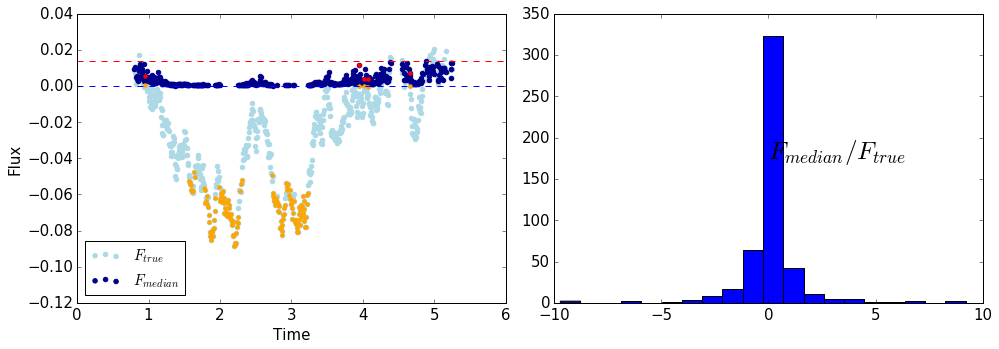

In [378]:
# 2)b)   F_median/  F_true 
fig,ax = plt.subplots(1,2, figsize=(14,5))
F_t = F_true[F_obs < 2*sigmaF]
hist_lim = 10
msk = abs(F_median / F_t) >hist_lim 
ax[0].scatter(t,F_t, color='lightblue',label=r'$F_{true}$')
ax[0].scatter(t,F_median, color='darkblue',label=r'$F_{median}$')
ax[0].scatter(t[msk], F_median[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
msk = abs(F_median / F_t) < hist_lim
ax[1].hist(F_median[msk] / F_t[msk], bins=20)
ax[0].set_xlabel('Time', fontsize=15)
ax[0].set_ylabel('Flux', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.5, y=0.5, s=r'$F_{median} / F_{true}$',transform = ax[1].transAxes, fontsize=25)
ax[0].legend(fontsize=15, loc='lower left')
plt.tight_layout()
plt.savefig('DRW_Flux_hist_2b.png')

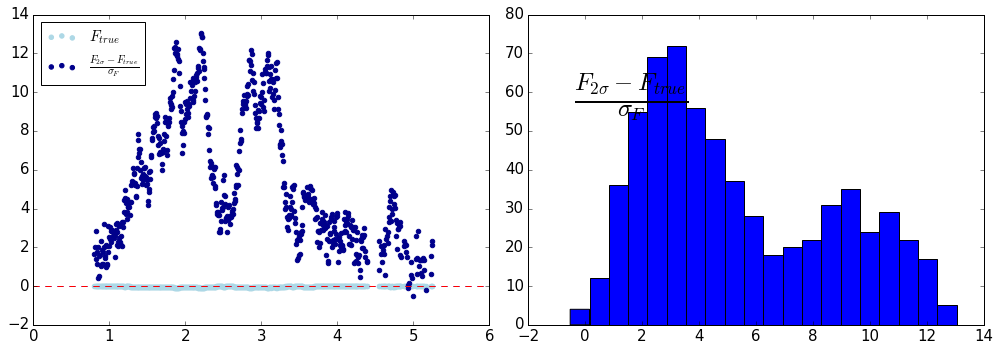

In [379]:
# 3) (F_2sig - F_true)  / sigmaF
fig,ax = plt.subplots(1,2, figsize=(14,5))
F_t = F_true[F_obs < 2*sigmaF]
F_plot = (F_2sig - F_t) / sigmaF
msk = abs(F_plot) > 100
ax[0].scatter(t,F_t, color='lightblue',label=r'$F_{true}$')
ax[0].scatter(t,F_plot, color='darkblue', label =r'$\frac{F_{2 \sigma} - F_{true}}{\sigma_{F}}$' )
ax[0].scatter(t[msk], F_plot[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].legend(fontsize=15, loc='upper left')
ax[0].axhline(2*sigmaF, c='red', ls='--')
msk = abs(F_plot) < 100
ax[1].hist(F_plot[msk], bins=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.1, y=0.7, s=r'$\frac{F_{2 \sigma} - F_{true}}{\sigma_{F}}$',transform = ax[1].transAxes, fontsize=35)
plt.tight_layout()
plt.savefig('DRW_Flux_hist_3.png')

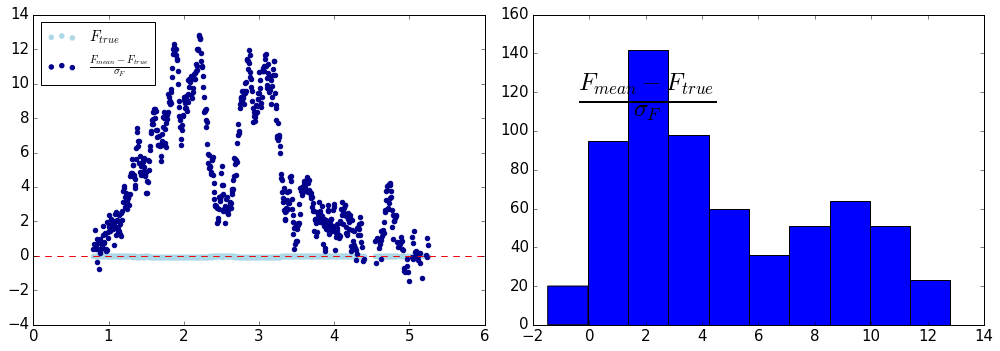

In [380]:
# 4)a) (F_mean - F_true)  / sigmaF
fig,ax = plt.subplots(1,2, figsize=(14,5))
F_t = F_true[F_obs < 2*sigmaF]
F_plot = (F_mean - F_t) / sigmaF
msk = abs(F_plot) > 100
ax[0].scatter(t,F_t, color='lightblue',label=r'$F_{true}$')
ax[0].scatter(t,F_plot, color='darkblue',label =r'$\frac{F_{mean} - F_{true}}{\sigma_{F}}$')
ax[0].scatter(t[msk], F_plot[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
ax[0].legend(fontsize=15, loc='upper left')
msk = abs(F_plot) < 100
ax[1].hist(F_plot[msk])
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.1, y=0.7, s=r'$\frac{F_{mean} - F_{true}}{\sigma_{F}}$',transform = ax[1].transAxes, fontsize=35)
plt.tight_layout()
plt.savefig('DRW_Flux_hist_4a.png')

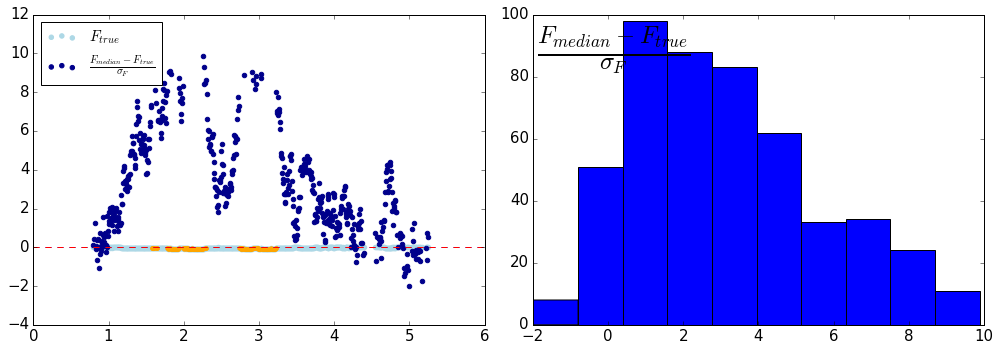

In [381]:
# 4)b) (F_median -  F_true)  / sigmaF
fig,ax = plt.subplots(1,2, figsize=(14,5))
F_t = F_true[F_obs < 2*sigmaF]
F_plot = (F_median- F_t) / sigmaF

msk = abs(F_plot) > 100
ax[0].scatter(t,F_t, color='lightblue', label=r'$F_{true}$')
ax[0].scatter(t,F_plot, color='darkblue', label=r'$\frac{F_{median} - F_{true}}{\sigma_{F}}$')
ax[0].scatter(t[msk], F_plot[msk], color='red', lw=0)
ax[0].scatter(t[msk], F_t[msk], color='orange', lw=0)
ax[0].axhline(0, ls='--')
ax[0].axhline(2*sigmaF, c='red', ls='--')
ax[0].legend(fontsize=15, loc='upper left')
msk = abs(F_plot) < 100
ax[1].hist(F_plot[msk])
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].text(x=0.01, y=0.85, s=r'$\frac{F_{median} - F_{true}}{\sigma_{F}}$',transform = ax[1].transAxes, fontsize=35)
plt.tight_layout()
plt.savefig('DRW_Flux_hist_4b.png')

In [265]:
#  Integral from x to infty over a normed zero-mean Gaussian (unit width) : 1 - cdf(x) ,  complementary CDF 
#  norm.sf(x)

#  The inverse survival function tells us what is the number for that area 
#  y = norm.sf(x)     <==>   x = norm.isf(y) 

#norm.isf(norm.sf(0.6))
sigmaF

0.058801315983781827

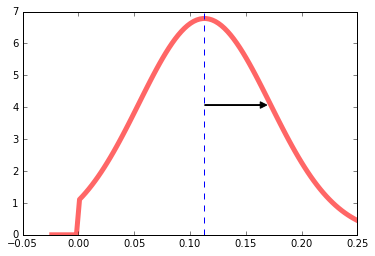

In [285]:
fig,ax = plt.subplots()
loc = F_faint[0]   # mu for a Gaussian 
scale = sigmaF  # sigma for a Gaussia n
x = np.linspace(norm(loc, scale).ppf(0.01), norm(loc, scale).ppf(0.99), 100)
y =norm(loc, scale).pdf(x)
y[x<0] = 0
ax.plot(x,y , 'r-', lw=5, alpha=0.6, label='norm pdf')
ax.axvline(loc, ls='--')
# https://philbull.wordpress.com/2012/04/05/drawing-arrows-in-matplotlib/
# ax.arrow (x1, y1, x2-x1,  y2-y1 )
ax.arrow( loc, 0.6*max(y),0.05 ,0 , fc="k", ec="k" , head_width=0.03*max(y), head_length=0.1*sigmaF)
